['3.', '0.2', ';', '(space', 'between', 'target', 'and', 'fisrt', 'element)']
['5.', '0.15', '-2.20064', '50', '/Q1Q/', ';']
['3.', '0.1', ';']
['5.', '0.2', '2.07774', '50', '/Q2Q/', ';']
['3.', '0.2', ';']
['5.01', '0.2', '-1.1624', '50', '/Q3Q/', ';']
['3.1', '2.181', ';']
['5.01', '0.2', '-1.0911', '30', '/Q4Q/', ';']
['3.', '0.15', ';']
['5.01', '0.2', '0.67445', '30', '/Q5Q/', ';']
['3.', '0.5', ';']
['3.', '0.5', '/GTR/;']
['4.', '0.5', '3', '0', '/B11/', ';']
['5.', '0.2', '-1.06', '30', '/Q1G/', ';']
['5.', '0.2', '0.9275', '30', '/Q2G/', ';']
['3.', '0.1', '/SL1E/;']
['(slit', '0.1', '-.2', '.2', 'tantalum', ';', ')']
['3.', '0.1;']
['5.', '0.2', '0.9275', '30', '/Q2G/', ';']
['5.', '0.2', '-1.06', '30', '/Q1G/', ';']
['3.', '0.1', ';']
['4.', '0.5', '3', '0', '/B12/', ';']
['3.', '0.25', '/col/', ';']
['3.', '0.25;']
['4.', '1', '-3', '0', '/B2/', ';']
['5.', '0.2', '-0.80839', '30', '/Q3G/', ';']
['5.', '0.2', '0.7217', '30', '/Q4G/', ';']
['3.', '0.1', '/SL2E/;']
['(slit',

Text(0, 0.5, 'nb of protons (arb. units)')

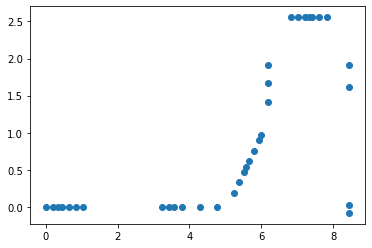

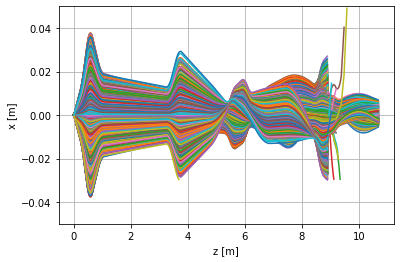

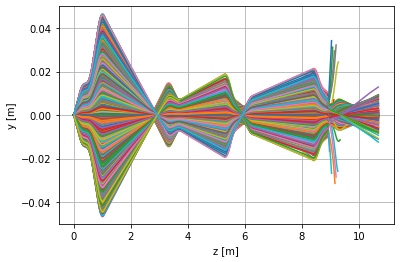

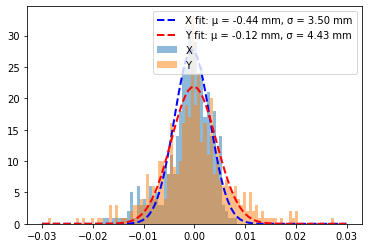

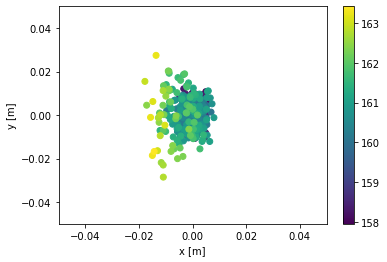

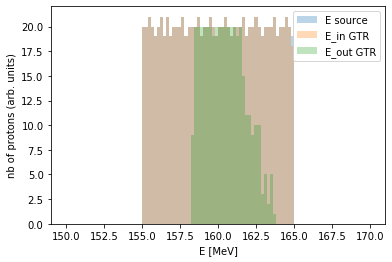

In [2]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from transfer_functions import transport_input, transport_count_lines, EtoP, GTR_layout_from_transport, PtoE, Brho_scaling, split_transport_file, gaussian
from scipy.optimize import curve_fit
from scipy.stats import norm


plt.close('all')


nb_part=1000

input_file = "C:/TRANS/for001.dat"
#input_file = "D:/beamline/transport/Transport code/inputs/HIL test 3T magnets double achromat.txt"


split_transport_file(input_file)


gap = 0.03
k1 = 0.5
k2 = 0

old_refE = 160 # default energy considered for fields bleow 
refE = 160
ref_p = EtoP(refE)
Brho  = 1/300*sqrt(refE**2+2*938*refE)


Brho_factor = Brho_scaling(old_refE,refE)    

kill_lost_particles = True
gapX = gap # case of CCT magnets

#######################################
# compute GTR drawing
nb_pts_z = transport_count_lines(input_file,1) 
layout = np.zeros(shape=[nb_pts_z,2]) 
layout = GTR_layout_from_transport(input_file,layout,old_refE)
plt.figure(55)
plt.scatter(layout[0:nb_pts_z-1,0],layout[0:nb_pts_z-1,1])



########################################
N_segments = 10
nb_pts_z = transport_count_lines(input_file,N_segments) 

###############################################################################
# initial conditions

beam = np.empty(shape=[nb_pts_z,7,nb_part]) 

for i in range(0,nb_part):
    
    
    z=0  
    it_z = 0
    
    sizeX = np.random.uniform(-0.00001,0.00001)
    sizeY = np.random.uniform(-0.00001,0.00001)
    
    #sizeX = 0.00001
    #sizeY = 0.00001
    
    #divX = np.random.normal(0,0.1/2.35) #100 mrad FWMH
    #divY = np.random.normal(0,0.1/2.35)
    
    divX = np.random.uniform(-0.05,0.05)
    divY = np.random.uniform(-0.05,0.05)
    
    #divX = 0.05*np.random.choice([-1,0,1])
    #divY = 0.05*np.random.choice([-1,0,1])
    
    #divX = 0.05 
    #divY = 0.05
    
    #divX=0
    #divY=0
    
    E = refE + 5*np.random.normal(0,1)
    E = refE + 1.5*np.random.uniform(-1,1)
    #E = refE + 1.5*np.random.choice([-1,0,1])
    E = refE + 5*(i-nb_part/2)/nb_part*2
    #E = refE +  1.5*(i-1)
    #E = refE
    
    
#    sizeX = np.random.uniform(-0.004,0.004)
#    sizeY = np.random.uniform(-0.004,0.004)
#    divX = np.random.uniform(-0.01,0.01)
#    divY = np.random.uniform(-0.01,0.01)
#    #sizeX = 0.004
#    #sizeY = 0.004
#    #divX = 0.01
#    #divY = 0.01
    
    
    p = EtoP(E)
    dponp = (p-ref_p)/ref_p
    beam[0,:,i] = np.array([z,sizeX,divX,sizeY,divY,0,dponp])
    
###############################################################################    
# extraction section
last_z = beam[it_z,0,:]    
last_itz = it_z 


for i in range(0,nb_part):  
    it_z = last_itz 
    [beam,it_z] = transport_input('transport_file_ESS.txt',beam,refE,i,N_segments,gap,k1,k2,last_z,last_itz,Brho_factor,kill_lost_particles,gap_X=gapX)
 

E_list_in = np.vectorize(PtoE)(ref_p*(1+beam[0,6,:]))
DeltaE = refE/100
nb_part_in_ESS = ((E_list_in < refE+DeltaE) & (E_list_in > refE-DeltaE)).sum()
nb_part_in_ESS2 = ((E_list_in < refE+2*DeltaE) & (E_list_in > refE-2*DeltaE)).sum()

E_list_out_ESS = np.vectorize(PtoE)(ref_p*(1+beam[it_z,6,:]))
E_list_out_ESS[np.isnan(E_list_out_ESS)] = 0 


nb_part_out_ESS = ((E_list_out_ESS < refE+DeltaE) & (E_list_out_ESS > refE-DeltaE)).sum()

print('ESS efficiency within E range [',refE-DeltaE,',',refE+DeltaE,']  = ',nb_part_out_ESS/max(nb_part_in_ESS,1)*100,'%')


###############################################################################    
# gantry section
last_z = beam[it_z,0,:]
last_itz = it_z 
it_z_GTR = it_z

for i in range(0,nb_part):  
    it_z = last_itz 
    [beam,it_z] = transport_input('transport_file_GTR.txt',beam,refE,i,N_segments,gap,k1,k2,last_z,last_itz,Brho_factor,kill_lost_particles,gap_X=gapX)

        




E_list_out_GTR = np.vectorize(PtoE)(ref_p*(1+beam[it_z,6,:]))
E_list_out_GTR[np.isnan(E_list_out_GTR)] = 0 


nb_part_out_GTR = ((E_list_out_GTR < refE+DeltaE) & (E_list_out_GTR > refE-DeltaE)).sum()

print('GTR efficiency within 1% E range [',refE-DeltaE,',',refE+DeltaE,']  = ',nb_part_out_GTR/max(nb_part_out_ESS,1)*100,'%')
print('total efficiency within 1% E range [',refE-DeltaE,',',refE+DeltaE,']  = ',nb_part_out_GTR/max(nb_part_in_ESS,1)*100,'%')

nb_part_out_GTR2 = ((E_list_out_GTR < refE+2*DeltaE) & (E_list_out_GTR > refE-2*DeltaE)).sum()
print('total efficiency within 2% E range [',refE-2*DeltaE,',',refE+2*DeltaE,']  = ',nb_part_out_GTR2/max(nb_part_in_ESS2,1)*100,'%')







plt.figure(0)
plt.plot(beam[0:it_z,0,:],beam[0:it_z,1,:])
plt.ylim((-0.05,0.05))
plt.xlabel('z [m]')
plt.ylabel('x [m]')
#plt.legend(np.vectorize(PtoE)(ref_p*(1+beam[it_z,6,:])))
plt.grid(which='major')
plt.figure(1)
plt.plot(beam[0:it_z,0,:],beam[0:it_z,3,:])
plt.ylim((-0.05,0.05))
plt.xlabel('z [m]')
plt.ylabel('y [m]')
plt.grid(which='major')
#plt.legend(np.vectorize(PtoE)(ref_p*(1+beam[it_z,6,:])))


################################################

plt.figure(4)

# filter NaN values
X_iso_filtered = beam[it_z,1,:][~np.isnan(beam[it_z,1,:])]
Y_iso_filtered = beam[it_z,3,:][~np.isnan(beam[it_z,3,:])]
# add filter on central values for the fit
maskX = np.logical_and(X_iso_filtered < 0.01,X_iso_filtered>-0.01)
maskY = np.logical_and(Y_iso_filtered < 0.01,Y_iso_filtered>-0.01)

(muX, sigmaX) = norm.fit(X_iso_filtered[maskX])
print('mu X = ',muX,' , sigma X = ',sigmaX)
(muY, sigmaY) = norm.fit(Y_iso_filtered[maskY])
print('mu Y = ',muY,' , sigma Y = ',sigmaY)


nb_bins = 100

n, bins, patches = plt.hist(X_iso_filtered,nb_bins,range=(-0.03,0.03),alpha=0.5,label="X")
X_spot = [bins[:-1], n]
hist_area = np.sum(n)*(max(bins)-min(bins))/len(bins)
# add a 'best fit' line
y = norm.pdf(bins, loc=muX, scale=sigmaX)*hist_area
plt.plot(bins, y, 'b--', linewidth=2,label='X fit: \u03BC = {:.2f} mm, \u03C3 = {:.2f} mm'.format(muX*1000,sigmaX*1000))

n, bins, patches = plt.hist(Y_iso_filtered,nb_bins,range=(-0.03,0.03),alpha=0.5,label="Y")
Y_spot = [bins[:-1], n]
hist_area = np.sum(n)*(max(bins)-min(bins))/len(bins)
# add a 'best fit' line
y = norm.pdf(bins, loc=muY, scale=sigmaY)*hist_area
plt.plot(bins, y, 'r--', linewidth=2,label='Y fit: \u03BC = {:.2f} mm, \u03C3 = {:.2f} mm'.format(muY*1000,sigmaY*1000))


plt.legend(loc='upper right')


################################################


plt.figure(41)
plt.scatter(beam[it_z,1,:],beam[it_z,3,:], c = np.vectorize(PtoE)(ref_p*(1+beam[0,6,:])))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.xlim((-0.05,0.05))
plt.ylim((-0.05,0.05))




plt.figure(5)
plt.hist(np.vectorize(PtoE)(ref_p*(1+beam[0,6,:])),100,range=(refE-10,refE+10),alpha=0.3,label="E source")
plt.hist(np.vectorize(PtoE)(ref_p*(1+beam[it_z_GTR,6,:])),100,range=(refE-10,refE+10),alpha=0.3,label="E_in GTR")
plt.hist(np.vectorize(PtoE)(ref_p*(1+beam[it_z,6,:])),100,range=(refE-10,refE+10),alpha=0.3,label="E_out GTR")
plt.legend(loc='upper right')
plt.xlabel('E [MeV]')
plt.ylabel('nb of protons (arb. units)')







[ 1.95859307e+01 -1.67760792e-04  4.03101463e-03  2.83606959e-01
  1.93996427e+00  1.85655995e-01]


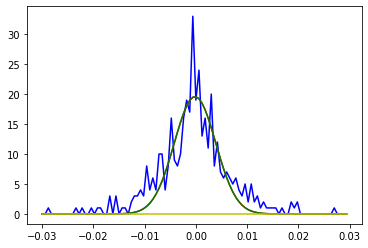

In [4]:
from sklearn import mixture
import matplotlib.pyplot
import matplotlib.mlab
import numpy as np
from pylab import *
from scipy.optimize import leastsq


x = Y_spot[:][0]
y = Y_spot[:][1]

def gaussian( x, params ):
    (c1, mu1, sigma1) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) 
    return res

def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y_proc)

# Remove background.
y_proc = np.copy(y)
y_proc[y_proc < 5] = 0.0

# Least squares fit. Starting values found by inspection.
fit = leastsq( double_gaussian_fit, [100,0,0.003,10,0,0.1] )
plot( x, y, c='b' )
plot( x, double_gaussian( x, fit[0] ), c='r' )

plot( x, gaussian( x, fit[0][0:3] ), c='g' )
plot( x, gaussian( x, fit[0][3:6] ), c='y' )
print(fit[0])

In [5]:
y_proc

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  6.,  0., 10.,
       10.,  0.,  8., 16.,  9.,  8., 10., 16., 19., 17., 33., 19., 24.,
       13., 16., 11., 20.,  8., 12.,  7.,  6.,  7.,  6.,  5.,  6.,  0.,
        0.,  5.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])